In [1]:
# -*- coding: utf-8 -*-
import pickle as pkl
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import math
import os
import numpy.linalg as la
import sys
from input_data import preprocess_data,load_sz_data,load_los_data,load_cal_data
from tgcn import tgcnCell
#from gru import GRUCell 

from visualization import plot_result,plot_error
from sklearn.metrics import mean_squared_error,mean_absolute_error
#import matplotlib.pyplot as plt
import time

time_start = time.time()
model_name = 'tgcn'
data_name = 'cal'
train_rate =  0.95
seq_len = 12
output_dim = pre_len = 9
batch_size = 64
lr = 0.001
training_epoch = 10000
gru_units = 64

pred_len = 1
###### load data ######
if data_name == 'cal':
    data, adj1 = load_cal_data('cal')

# ###### adj normalize
# adj1 = np.mat(adj,dtype=np.float32)
thres = 10000
adj = adj1
print(adj)
adj[adj>thres]=0
adj = adj/np.max(adj)
for i in range(adj.shape[0]):
    for j in range(adj.shape[0]):
        if i == j:
            adj[i,j] = 1
        else:
            if adj[i,j]>0:
                adj[i,j] = 1-adj[i,j]
    
print(adj)
# adj = adj1
time_len = 9112
num_nodes = data.shape[1]
data1 =np.mat(data,dtype=np.float32)
#### normalization
max_value = np.max(data1)
# min_value = np.min(data1)
data1 = data1/max_value
#data1 = (data1-min_value)/(max_value-min_value)
# mean = np.mean(data1)
# std = np.std(data1)
# data1 = (data1-mean)/std
# max_value = std
# print(np.max(data1),np.min(data1))
trainX, trainY, testX15, testY15 = preprocess_data(data1, time_len, train_rate, seq_len, 3)
trainX, trainY, testX30, testY30 = preprocess_data(data1, time_len, train_rate, seq_len, 6)
trainX, trainY, testX45, testY45 = preprocess_data(data1, time_len, train_rate, seq_len, 9)
totalbatch = int(trainX.shape[0]/batch_size)
training_data_count = len(trainX)

def TGCN(_X, _weights, _biases):
    ###
    cell_1 = tgcnCell(gru_units, adj, num_nodes=num_nodes)
    cell = tf.nn.rnn_cell.MultiRNNCell([cell_1], state_is_tuple=True)
    _X = tf.unstack(_X, axis=1)
    outputs, states = tf.nn.static_rnn(cell, _X, dtype=tf.float32)
    m = []
    for i in outputs:
        o = tf.reshape(i,shape=[-1,num_nodes,gru_units])
        o = tf.reshape(o,shape=[-1,gru_units])
        m.append(o)
    last_output = m[-1]
    output = tf.matmul(last_output, _weights['out']) + _biases['out']
    output = tf.reshape(output,shape=[-1,num_nodes,pred_len])
    output = tf.transpose(output, perm=[0,2,1])
    output = tf.reshape(output, shape=[-1,num_nodes])
    return output, m, states
        
###### placeholders ######
inputs = tf.placeholder(tf.float32, shape=[None, seq_len, num_nodes])
labels = tf.placeholder(tf.float32, shape=[None, pred_len, num_nodes])

# Graph weights
weights = {
    'out': tf.Variable(tf.random_normal([gru_units, pred_len], mean=1.0), name='weight_o')}
biases = {
    'out': tf.Variable(tf.random_normal([pred_len]),name='bias_o')}

if model_name == 'tgcn':
    pred,ttts,ttto = TGCN(inputs, weights, biases)

y_pred = pred
      
###### Initialize session ######
variables = tf.global_variables()
saver = tf.train.Saver(tf.global_variables())  
#sess = tf.Session()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())

out = 'out/%s'%(model_name)
#out = 'out/%s_%s'%(model_name,'perturbation')
path1 = 'pre%r_vs_lr%r_epoch%r'%(pre_len,lr,training_epoch)
path = os.path.join(out,path1)
if not os.path.exists(path):
    os.makedirs(path)

saver.restore(sess, 'out/tgcn/pre3_vs_lr0.0001_epoch10000_/model_100/TGCN_pre_0-0')
test_output15 = sess.run(y_pred, feed_dict = {inputs:testX15})
test_output15 = np.reshape(test_output15,[-1,num_nodes])
test_output15 = test_output15*max_value

saver.restore(sess, 'out/tgcn/pre6_vs_lr0.0001_epoch10000/model_100/TGCN_pre_200-200')
test_output30 = sess.run(y_pred, feed_dict = {inputs:testX30})
test_output30 = np.reshape(test_output30,[-1,num_nodes])
test_output30 = test_output30*max_value

saver.restore(sess, 'out/tgcn/pre9_tgcn_lr0.0001_batch64_unit64_seq12_epoch10000_stdnorm/model_100/TGCN_pre_100-100')
test_output45 = sess.run(y_pred, feed_dict = {inputs:testX45})
test_output45 = np.reshape(test_output45,[-1,num_nodes])
test_output45 = test_output45*max_value

[[    0.    3165.94  8731.54 ... 22614.08 26339.9  10012.42]
 [ 3165.94     0.    5625.76 ... 21118.47 24716.98  9915.24]
 [ 8731.54  5625.76     0.   ... 20827.51 23992.78 13057.44]
 ...
 [22614.08 21118.47 20827.51 ...     0.    3825.01 13725.79]
 [26339.9  24716.98 23992.78 ...  3825.01     0.   17550.36]
 [10012.42  9915.24 13057.44 ... 13725.79 17550.36     0.  ]]
[[1.         0.68339365 0.12681195 ... 0.         0.         0.        ]
 [0.68339365 1.         0.43740206 ... 0.         0.         0.00843733]
 [0.12681195 0.43740206 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.61748408 0.        ]
 [0.         0.         0.         ... 0.61748408 1.         0.        ]
 [0.         0.00843733 0.         ... 0.         0.         1.        ]]
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by 

In [18]:
testY150 = np.squeeze(testY15)*max_value
testY300 = np.squeeze(testY30)*max_value
testY450 = np.squeeze(testY45)*max_value

In [19]:
print(max_value)

82.6


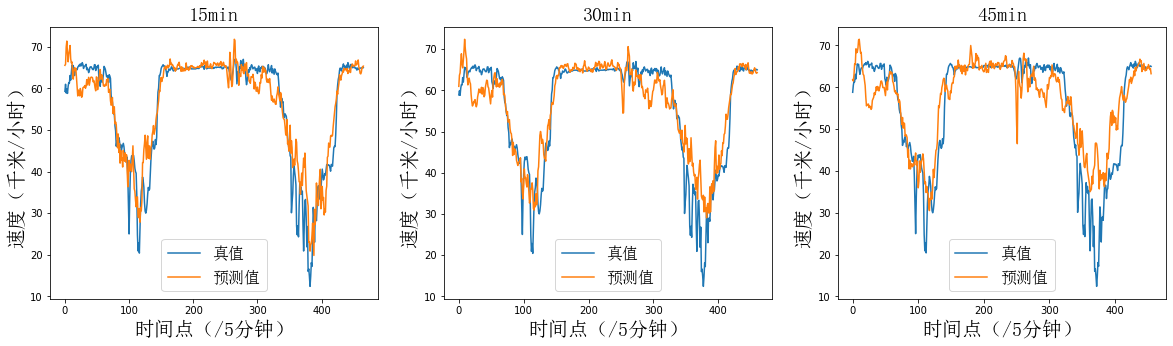

In [44]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
font_set = FontProperties(fname=r"/usr/share/fonts/myfonts/SIMSUN.TTC", size=16)

def visual(ax,true, pred, pre_len):
    ax.plot(true,label=u'真值')
    ax.plot(pred,label=u'预测值')
    ax.set_xlabel('时间点（/5分钟）',fontproperties=font_set, fontsize=20)
    ax.set_ylabel('速度（千米/小时）',fontproperties=font_set, fontsize=20)
    ax.set_title('%smin'%pre_len,fontproperties=font_set, fontsize=20)
    ax.legend(prop =font_set)
#     color =plt.cm.Set2(random.choice(xrange(plt.cm.Set2.N)))
    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=[20,5])
ax1, ax2, ax3 = axes.ravel()
l = 101
visual(ax1, testY150[:,l], test_output15[:,l], 15)
visual(ax2, testY300[:,l], test_output30[:,l], 30)
visual(ax3, testY450[:,l], test_output45[:,l], 45)
plt.savefig("../../../Writing/traffic_prediction/fig/GCN_compare%s.jpg"%l)

In [46]:
import numpy.linalg as la
from sklearn.metrics import mean_squared_error,mean_absolute_error
def evaluation(a,b):
    rmse = math.sqrt(mean_squared_error(a,b))
    mae = mean_absolute_error(a, b)
    F_norm = la.norm(a-b)/la.norm(a)
    r2 = 1-((a-b)**2).sum()/((a-a.mean())**2).sum()
    var = 1-(np.var(a-b))/np.var(a)
    print('rmse',rmse,'mae',mae,'r2', r2,'var',var,'accuracy',1-F_norm,)
    return rmse, mae, r2, var#, 1-F_norm
# print(true15)
print(evaluation(testY150, test_output15))
print(evaluation(testY300, test_output30))
print(evaluation(testY450, test_output45))

rmse 5.4565658425485335 mae 3.4712868 r2 0.8809251561760902 var 0.8812175989151001 accuracy 0.9053141921758652
(5.4565658425485335, 3.4712868, 0.8809251561760902, 0.8812175989151001)
rmse 6.9478152456892825 mae 4.4245753 r2 0.8073555380105972 var 0.8078709542751312 accuracy 0.879347912967205
(6.9478152456892825, 4.4245753, 0.8073555380105972, 0.8078709542751312)
rmse 7.987110721850891 mae 5.164645 r2 0.7461305856704712 var 0.7474207282066345 accuracy 0.8611999154090881
(7.987110721850891, 5.164645, 0.7461305856704712, 0.7474207282066345)
